In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from exp_PseudoBoltzmannStates_average import*

### Individual instances

In [11]:
# Plot of the probability amplitude distribution of the final QAOA state, and fit to Boltzmann distribution.
#*****************************************************************************************************

def probamplitude_distribution_QAOA(ax,N,ptname='MAXCUT',graph_type="Gnm",graph_arguments=0.9,
cmap='viridis',color='black',cost_function='GS-Probability',ylim=(10**(-11)*5,10**(-2)*2),save_file=False):

    if ptname=='Random energies':
        #We multiply by 5 to have an energy range similar to the other problems.
        E = 5*np.random.normal(loc=0,scale=1,size=2**N)
    else:
        E, J = generate_interaction(N, ptname, graph_type, graph_arguments)

    θ, γ = optimization(N, E, cost_function=cost_function)
    ψ2 = QAOA(θ,γ,N,E) 

    ####Boltzmann Fit
    p,cov = np.polyfit(E, np.log(ψ2), 1,cov=True)
    β = -p[0]
    βerror = np.sqrt(np.diag(cov))[0] #sigma of β estimation
    perr = np.sqrt(np.diag(cov)) #standard deviation errors
    nstd2 = 5. # to draw nstd-sigma intervals (2-sigma=95%ci; 3-sigma=99.7%ci)
    popt_up2 = p + nstd2 * perr
    popt_dw2 = p - nstd2 * perr
    
    ####Plot
    dataframe = pd.DataFrame(columns=['Energy','Amplitude','Fit'])
    dataframe['Energy']=E
    dataframe['Amplitude']=ψ2
    dataframe['Fit']=np.exp(np.polyval(p, E))
    
    sns.set(rc={'figure.figsize':(10,8),"lines.linewidth": 2,"lines.markersize": 5,"font.family":"Times New Roman",
                'mathtext.fontset':"stix"},style='whitegrid')
    fontsize=36
    values = np.vstack([dataframe["Energy"], np.log(dataframe["Amplitude"])])
    kernel = stats.gaussian_kde(values)(values)
    plotsc = sns.scatterplot(data=dataframe, x="Energy", y='Amplitude',ax=ax, s=4,
                             label='Probability amplitude of one state',c=kernel,cmap=cmap)

    #Plot the fit results
    ax.plot(E,np.exp(np.polyval(p, E)),color=color,linewidth=2,label='Boltzmann Fit')
    E = np.sort(E)
    ax.fill_between(E,np.exp(np.polyval(popt_up2, E)), np.exp(np.polyval(popt_dw2, E)), color=color, alpha=.2, 
                    label=r'5$\sigma$ confidence interval')
    ax.text(0,10**(-9),r'$\beta =$'+str(round(β,3))+r'$\pm$'+str(round(βerror,3)),color=color,
            fontsize=27,weight='bold')
    ####
    ax.set_yscale('log')
    ax.set_ylabel(r'$\mathdefault{\vert}\langle\mathdefault{\mathbf{x}|\Psi}\rangle\mathdefault{\vert}^2$'
                  ,fontsize=fontsize)
    ax.set_xlabel(r'Energy ($E_{\mathbf{x}}$)',fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(ylim)

    if save_file:
        plt.savefig(save_file)

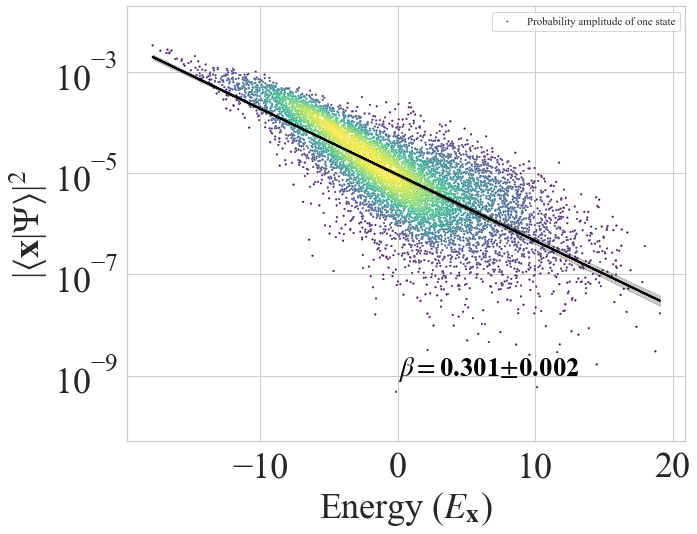

In [38]:
fig, ax = plt.subplots()
probamplitude_distribution_QAOA(ax,14,ptname='MAXCUT',graph_type="Gnm",graph_arguments=0.9,cost_function='Energy',save_file='probamplitude_distr_MAXCUT_den09.svg')

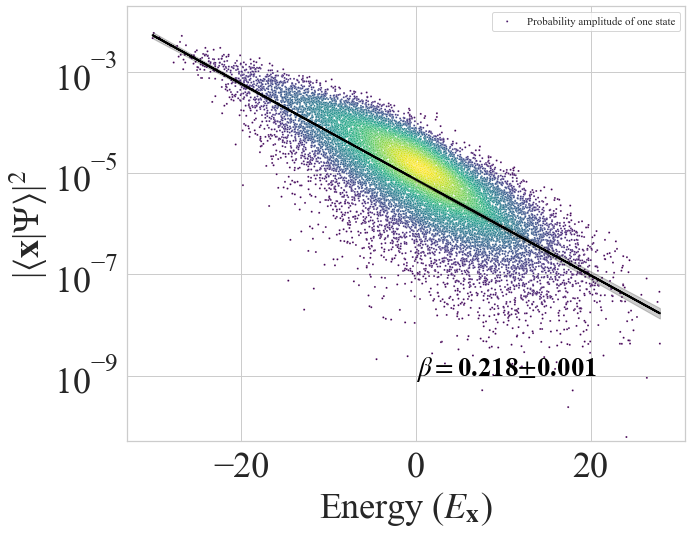

In [30]:
fig, ax = plt.subplots()
probamplitude_distribution_QAOA(ax,14,ptname='QUBO',graph_type="Gnm",graph_arguments=0.9,cost_function='Energy',save_file='probamplitude_distr_QUBO_den09.svg')

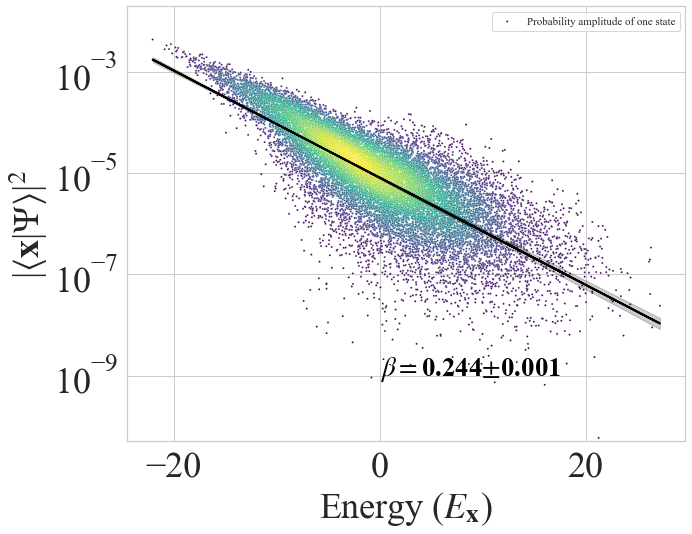

In [31]:
fig, ax = plt.subplots()
probamplitude_distribution_QAOA(ax,14,ptname='Random_Ising',graph_type="Gnm",graph_arguments=0.9,cost_function='Energy',save_file='probamplitude_distr_RandomIsing_den09.svg')

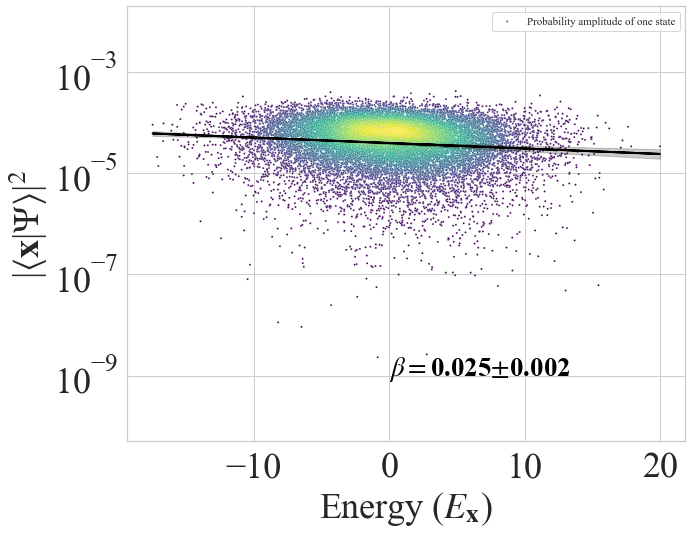

In [13]:
fig, ax = plt.subplots()
probamplitude_distribution_QAOA(ax,14,ptname='Random energies',graph_type="Gnm",graph_arguments=0.9,cost_function='Energy')

### Average results

In [10]:
# Plot of the average probability amplitude distribution of the final QAOA state over many samples, and fit to Boltzmann distribution.
#*****************************************************************************************************
def plot_PseudoBoltzmannState_average(ax,data,save_file,samples=500,nintervals=100,colors=['red','darkblue'],problem='MAXCUT',
ylim=(10**(-8),10**(-2)*2)):
    """Plot the average probability amplitude of every eigenstates x versus its normalized energy (Ex-Emin/(Emax-Emin))."""

    #We compute the average amplitudes in each interval from the amplitudes of the samples
    av_amplitudes=np.zeros(nintervals)    
    nsamples=np.zeros(nintervals)
    for i in range(samples):
        av_amplitudes+=data['Average Amplitude'][i]
        nsamples+=np.where(data['Average Amplitude'][i] > 0, 1, 0)
    av_amplitudes = av_amplitudes/nsamples
    energy_intervals = [j/nintervals for j in range(nintervals)]

    #Average Normalization factor: (E_max - E_min)
    normcte = np.mean(data['Normalization factor'])
    normcte_err = np.std(data['Normalization factor'])

    #Boltzmann Fit (we estimate the inverse temperature β by dividing by the mean of the normalization constants "normcte")
    p,cov = np.polyfit(energy_intervals,np.log(av_amplitudes), 1,cov=True)
    β = -p[0]/normcte
    βerror = np.sqrt((np.sqrt(np.diag(cov))[0]/normcte)**2+(p[0]*normcte_err/normcte**2)**2) #sigma of β estimation
    
    #Fitting error 
    perr = np.sqrt(np.diag(cov)) #standard deviation errors
    nstd5 = 5. # to draw nstd-sigma intervals (2-sigma=95%ci; 3-sigma=99.7%ci)
    popt_up2 = p + nstd5 * perr
    popt_dw2 = p - nstd5 * perr
    
    #Plot
    #To use seaborn, first we sort in a new DataFrame the amplitudes with their corresponding energy interval.
    #In data['Average Amplitude'][i][j] the "i" identifies the sample, and "j" the average amplitude in each enegy interval  
    dataframe = pd.DataFrame(columns=['Energy Interval','Amplitude'])
    dataframe['Energy Interval']=[j/nintervals if data['Average Amplitude'][i][j]>0 else None 
                                    for i in range(samples) for j in range(nintervals)]
    dataframe['Amplitude']=[data['Average Amplitude'][i][j] if data['Average Amplitude'][i][j]>0 else None 
                                for i in range(samples) for j in range(nintervals)]
    
    sns.set(rc={'figure.figsize':(10,8),"lines.linewidth": 1,"lines.markersize": 10,"font.family":"Times New Roman",
                'mathtext.fontset':"stix"},style='whitegrid')
    fontsize=36

    sns.lineplot(data=dataframe, x="Energy Interval", y='Amplitude',color=colors[0],ax=ax,linestyle='', err_style='bars',marker='.',label=problem,ci=99)

    ax.plot(energy_intervals,np.exp(np.polyval(p, energy_intervals)),color=colors[1],linewidth=3,label='Boltzmann Fit')
    ax.fill_between(energy_intervals,np.exp(np.polyval(popt_up2, energy_intervals)), 
                    np.exp(np.polyval(popt_dw2, energy_intervals)), color=colors[1], alpha=.2, 
                    label=r'5$\sigma$ confidence interval')
    ax.set_yscale('log')
    
    ax.text(0.1,10**(-5),r'$\beta =$'+str(round(β,2))+r'$\pm$'+str(round(βerror,2)),color=colors[1],
            fontsize=27,weight='bold')
    ax.set_ylabel(r'Average $\mathdefault{\vert}\langle\mathdefault{\mathbf{x}|\Psi}\rangle\mathdefault{\vert}^2$'
                  ,fontsize=fontsize)
    ax.set_xlabel(r'Normalized Energy $\left(\frac{E_{\mathbf{x}}-E_{\mathdefault{min}}}{E_{\mathdefault{max}}-E_{\mathdefault{min}}}\right)$'
                  ,fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(ylim)

    plt.savefig(save_file)
    return

In [3]:
#LOAD DATA

with open('expts/exp_PseudoBoltzmannStatesAverage-MAXCUT_nq14-14_nsamples1000_Gnm0.9_Energy.pkl', 'rb') as f: 
    maxcut_average_energy=pickle.load(f)
with open('expts/exp_PseudoBoltzmannStatesAverage-QUBO_nq14-14_nsamples1000_Gnm0.9_Energy.pkl', 'rb') as f: 
    qubo_average_energy=pickle.load(f)
with open('expts/exp_PseudoBoltzmannStatesAverage-Random_Ising_nq14-14_nsamples1000_Gnm0.9_Energy.pkl', 'rb') as f: 
    ising_average_energy=pickle.load(f)

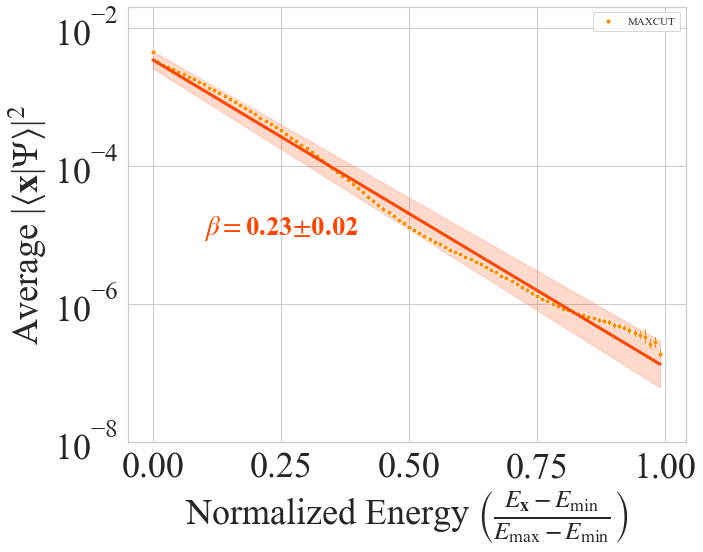

In [5]:
file = 'pictures/Pseudobolztmannstate_average_maxcut_14q_energy.svg'
fig, ax = plt.subplots()
plot_PseudoBoltzmannState_average(ax,maxcut_average_energy,file,colors=['darkorange','orangered'],
problem='MAXCUT',samples=1000,nintervals=100)

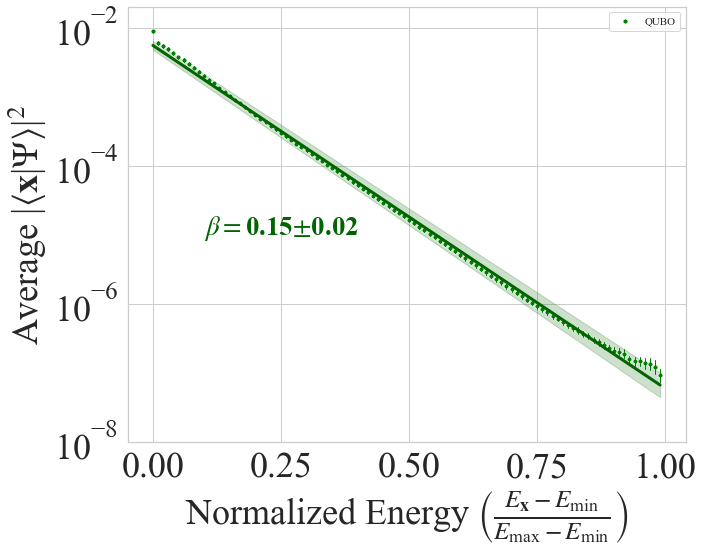

In [6]:
file = 'pictures/Pseudobolztmannstate_average_qubo_14q_energy.svg'
fig, ax = plt.subplots()
plot_PseudoBoltzmannState_average(ax,qubo_average_energy,file,colors=['green','darkgreen'],
problem='QUBO',samples=1000,nintervals=100)

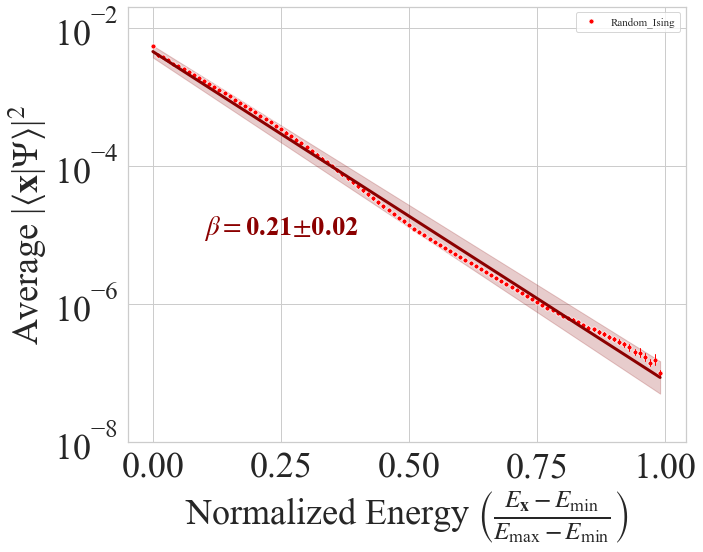

In [7]:
file = 'pictures/Pseudobolztmannstate_average_ising_14q_energy.svg'
fig, ax = plt.subplots()
plot_PseudoBoltzmannState_average(ax,ising_average_energy,file,colors=['red','darkred'],
problem='Random_Ising',samples=1000,nintervals=100)